Required packages and Installation:

*   numpy
*   pandas
*   tensorflow
*   matplotlib/seaborn




In [2]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt



In this step, we import the libraries required for the implementation of the anomaly detection algorithm using an autoencoder.
We import pandas for reading and manipulating the dataset, TensorFlow and Keras for building the autoencoder model, and scikit-learn for calculating the precision, recall, and F1 score.

In [4]:
data = pd.read_csv(
    'ambient_temperature_system_failure.csv')

# Exclude datetime column
data_values = data.drop('timestamp',
                        axis=1).values

# Convert data to float type
data_values = data_values.astype('float32')

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,
                              columns=data.columns[1:])

# Add back datetime column
data_converted.insert(0, 'timestamp',
                      data['timestamp'])


We load a dataset called“ambient_temperature_system_failure.csv” from the Numenta Anomaly Benchmark (NAB) dataset, which contains time-series data of ambient temperature readings from a system that experienced a failure.

The panda’s library is used to read the CSV file from a remote location on GitHub and store it in a variable called “data”.

Now, the code drops the “timestamp” column from the “data” variable, since it is not needed for data analysis purposes. The remaining columns are stored in a variable called “data_values”.
Then, the “data_values” are converted to the

*   Now, the code drops the “timestamp” column from the “data” variable, since it is not needed for data analysis purposes. The remaining columns are stored in a variable called “data_values”.

*   Then, the “data_values” are converted to the “float32” data type to reduce memory usage, and a new pandas DataFrame called “data_converted” is created with the converted data. The columns of “data_converted” are labeled with the original column names from “data”, except for the “timestamp” column that was previously dropped.

*  Finally, the code adds the “timestamp” column back to “data_converted” at the beginning using the “insert()” method. The resulting DataFrame “data_converted” has the same data as “data” but without the unnecessary “timestamp” column, and the data is in a format that can be used for analysis and visualization.


In [5]:
data_converted = data_converted.dropna()


# Anomaly Detection using Autoencoder

It is a type of neural network that learns to compress and then reconstruct the original data, allowing it to identify anomalies in the data.




In [6]:
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
    'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index


Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5080.9126
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5093.0234
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5103.2056
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5094.2349
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5087.1685
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5086.9082
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5096.5352
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5103.9668
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5093.0425
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5097.3398
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5099.4165
Epoch 12/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5095.2505
Epoch 13/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5088.2866
Epoch 14/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5101.2778
Epoch 15/50
228

The autoencoder is used to identify any deviations from the regular patterns in the data that are learned from the data. To reduce the *mean squared error* between the input and the output, the model is trained. The reconstruction error for each data point is determined using the trained model and is utilized as an anomaly score.

In [7]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')


Here, we define an anomaly detection threshold and assess the model’s effectiveness using precision, recall, and F1 score. Recall is the ratio of true positives to all real positives, whereas precision is the ratio of genuine positives to all projected positives.

In [8]:
test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  1.0
Recall:  1.0
F1 Score:  1.0


# Visualizing the Anomaly
Now let’s plot the anomalies which are predicted by the model and get a feel for whether the predictions made are correct or not by plotting the anomalous examples with red marks with the complete data.

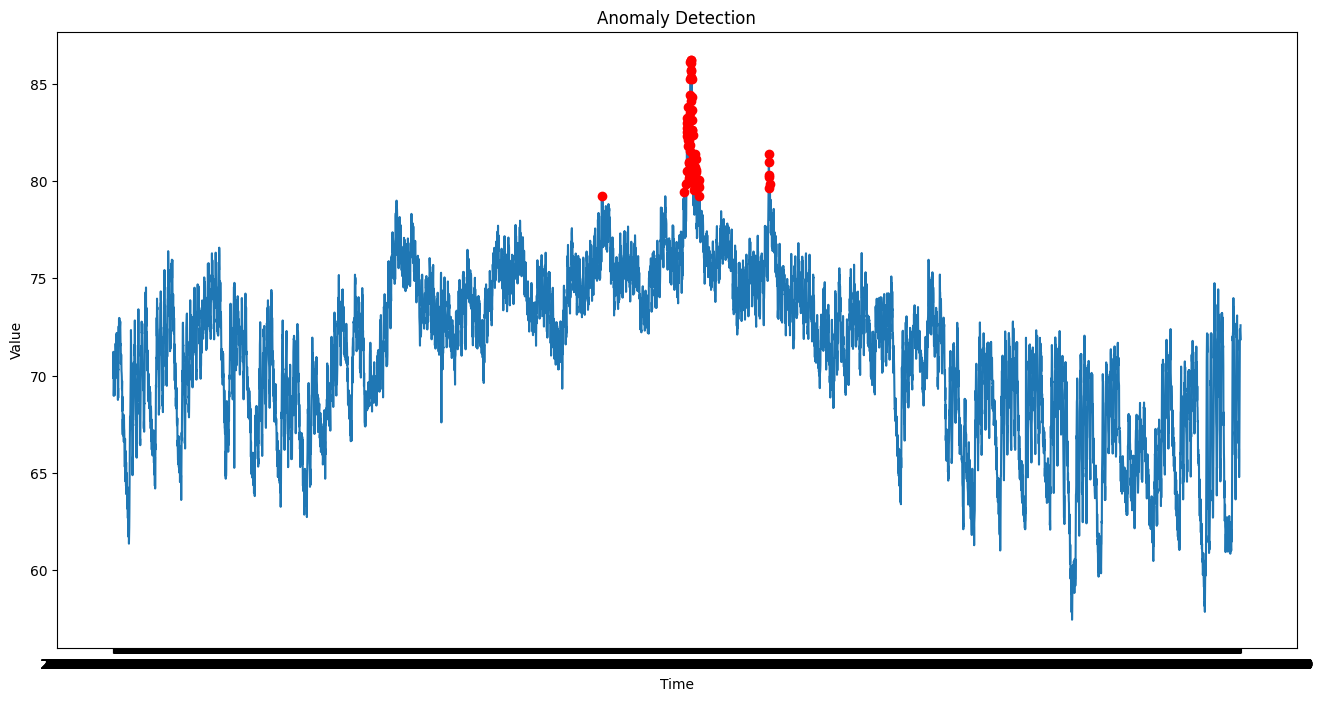

In [9]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
